# Store Sales - Time Series Analysis

### Intro and objectives
#### Apply the concepts learned so far in a real use case

### In this lab you will learn:
1. Open a set of files
2. Combine and merge large datasets
2. Transform dataframes
3. Process time series

## What I hope you'll get out of this lab
* Gain experience processing real datasets
* Compute basic insigths from data given to you

In [10]:
import pandas as pd
import glob
import os
from zipfile import ZipFile
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### The data comes from an Ecuador company as known as Corporación Favorita and it is a large grocery retailer. Also, the company operates in other countries in South America.



#### There are 54 stores and 33 prodcut families in the data. The time serie starts from 2013-01-01 and finishes in 2017-08-31. However, you know that Kaggle gives us splitted two data as train and test. The dates in the test data are for the 15 days after the last date in the training data. Date range in the test data will be very important to us while we are defining a cross-validation strategy and creating new features.


#### There are 3 datasets:
Train

1.   Sales
2.   Store
3.   Transactions


#### The sales data contains time series of the stores and the product families combination. The sales column gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).The onpromotion column gives the total number of items in a product family that were being promoted at a store at a given date.


#### Stores data gives some information about stores such as city, state, type, cluster.

#### Transaction data is highly correlated with train's sales column. You can understand the sales patterns of the stores.



In [11]:
# Import
SalesDataFrame = pd.read_csv("https://raw.githubusercontent.com/thousandoaks/Python4DS103/main/data/storesales/train.zip")
StoresDataFrame = pd.read_csv("https://raw.githubusercontent.com/thousandoaks/Python4DS103/main/data/storesales/stores.csv")
  
TransactionsDataFrame = pd.read_csv("https://raw.githubusercontent.com/thousandoaks/Python4DS103/main/data/storesales/transactions.csv").sort_values(["store_nbr", "date"])

In [12]:
SalesDataFrame.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [13]:
StoresDataFrame.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [14]:
TransactionsDataFrame.head()

,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520


In [15]:
# Datetime
SalesDataFrame["date"] = pd.to_datetime(SalesDataFrame['date'])

TransactionsDataFrame["date"] = pd.to_datetime(TransactionsDataFrame['date'])

In [16]:
# Data types
# We use the alternate notation to refer to a Pandas column
SalesDataFrame.onpromotion = SalesDataFrame.onpromotion.astype("float16")
SalesDataFrame.sales = SalesDataFrame.sales.astype("float32")
StoresDataFrame.cluster = StoresDataFrame.cluster.astype("int8")



### 1. Analysis of Transactions


In [17]:
SalesDataFrame

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0.0
1,1,2013-01-01,1,BABY CARE,0.000000,0.0
2,2,2013-01-01,1,BEAUTY,0.000000,0.0
3,3,2013-01-01,1,BEVERAGES,0.000000,0.0
4,4,2013-01-01,1,BOOKS,0.000000,0.0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.132996,0.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,1.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8.0


#### We group by date and store number to compute the sum of sales per store and day

In [18]:
SalesDataFrameGrouped=SalesDataFrame.groupby(["date", "store_nbr"])['sales'].sum().reset_index()

In [19]:
SalesDataFrameGrouped

,date,store_nbr,sales
0,2013-01-01,1,0.000000
1,2013-01-01,2,0.000000
2,2013-01-01,3,0.000000
3,2013-01-01,4,0.000000
4,2013-01-01,5,0.000000
...,...,...,...
90931,2017-08-15,50,16879.121094
90932,2017-08-15,51,20154.558594
90933,2017-08-15,52,18600.046875
90934,2017-08-15,53,8208.189453


### We merged the previous `DataFrame` with the transactions `DataFrame`

In [20]:
SalesWithTransactionsDataFrame=pd.merge(SalesDataFrameGrouped,TransactionsDataFrame, how = "left")

In [21]:
SalesWithTransactionsDataFrame

,date,store_nbr,sales,transactions
0,2013-01-01,1,0.000000,NaN
1,2013-01-01,2,0.000000,NaN
2,2013-01-01,3,0.000000,NaN
3,2013-01-01,4,0.000000,NaN
4,2013-01-01,5,0.000000,NaN
...,...,...,...,...
90931,2017-08-15,50,16879.121094,2804.0
90932,2017-08-15,51,20154.558594,1573.0
90933,2017-08-15,52,18600.046875,2255.0
90934,2017-08-15,53,8208.189453,932.0


#### From the following figure we observe a strong correlation between sales and transactions. Indeed this is expected as higher transactions lead to higher sales!

In [22]:
SalesWithTransactionsDataFrame[['sales','transactions']].corr()

,sales,transactions
sales,1.000000,0.837384
transactions,0.837384,1.000000


# 1. Analysis of transactions




#### The following figure outlines the evolution of transactions accross time and stores

#### There is a stable pattern in Transaction. All months are similar except December from 2013 to 2017 by boxplot. In addition, we've just seen same pattern for each store in previous plot. Store sales had always increased at the end of the year.

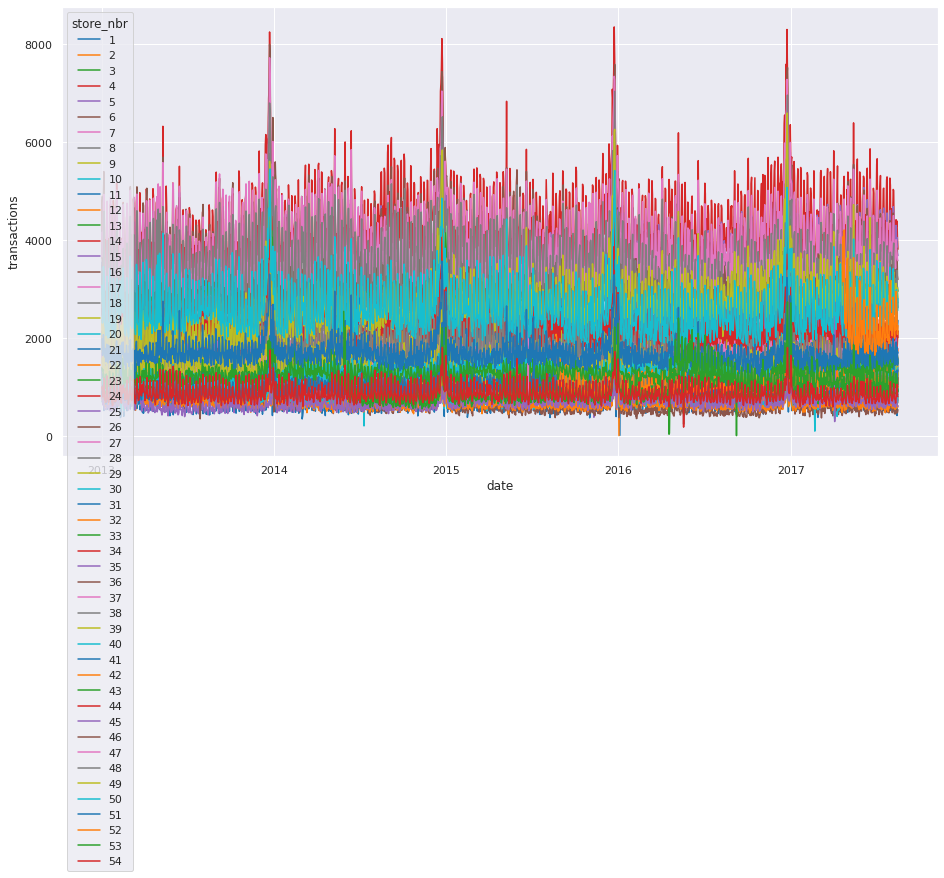

In [23]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(data=SalesWithTransactionsDataFrame,x='date', y='transactions',hue='store_nbr',palette="tab10")

In [24]:
SalesWithTransactionsDataFrame['year'] = pd.DatetimeIndex(SalesWithTransactionsDataFrame['date']).year
SalesWithTransactionsDataFrame['month'] = pd.DatetimeIndex(SalesWithTransactionsDataFrame['date']).month
SalesWithTransactionsDataFrame['day'] = pd.DatetimeIndex(SalesWithTransactionsDataFrame['date']).day
SalesWithTransactionsDataFrame['dayofweek'] = pd.DatetimeIndex(SalesWithTransactionsDataFrame['date']).dayofweek


In [25]:
SalesWithTransactionsDataFrame.sample(5)

,date,store_nbr,sales,transactions,year,month,day,dayofweek
63939,2016-04-02,4,18919.644531,1662.0,2016,4,2,5
23759,2014-03-17,54,6563.822266,869.0,2014,3,17,0
35356,2014-10-18,41,11330.017578,1181.0,2014,10,18,5
20481,2014-01-16,16,6762.630859,937.0,2014,1,16,3
15119,2013-10-07,54,4191.958008,808.0,2013,10,7,0


In [26]:
SalesWithTransactionsDataFrame.set_index('date',inplace=True)

In [27]:
SalesWithTransactionsDataFrame

,store_nbr,sales,transactions,year,month,day,dayofweek
date,,,,,,,
2013-01-01,1,0.000000,NaN,2013,1,1,1
2013-01-01,2,0.000000,NaN,2013,1,1,1
2013-01-01,3,0.000000,NaN,2013,1,1,1
2013-01-01,4,0.000000,NaN,2013,1,1,1
2013-01-01,5,0.000000,NaN,2013,1,1,1
...,...,...,...,...,...,...,...
2017-08-15,50,16879.121094,2804.0,2017,8,15,1
2017-08-15,51,20154.558594,1573.0,2017,8,15,1
2017-08-15,52,18600.046875,2255.0,2017,8,15,1


#### The following figure shows the moving monthly average of transactions.We observe an increase in transactions in December

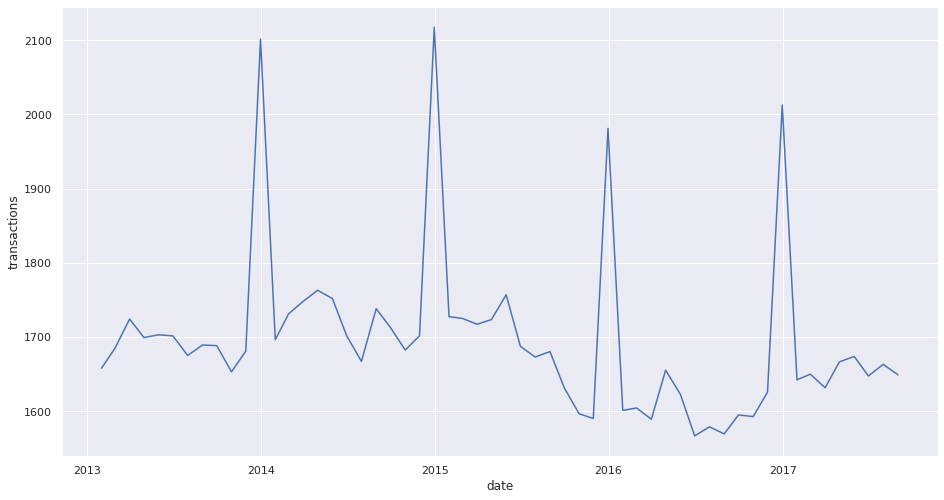

In [28]:
DataToPlot=SalesWithTransactionsDataFrame['transactions'].resample('M').mean()


sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(data=DataToPlot)

## Which months of the year are the most profitable ?
#### We want to visualize this information as a heatmap, this requires the data in wide format. We use the method pandas.pivot_table() 

In [29]:
SalesWithTransactionsDataFramePivoted=pd.pivot_table(SalesWithTransactionsDataFrame, values='transactions', index='month',
                    columns=['year'], aggfunc=np.sum)

In [30]:
SalesWithTransactionsDataFramePivoted

year,2013,2014,2015,2016,2017
month,,,,,
1,2289558.0,2393528.0,2489059.0,2371205.0,2612848.0
2,2169615.0,2278167.0,2345984.0,2465798.0,2448370.0
3,2458683.0,2545427.0,2625500.0,2607658.0,2680645.0
4,2344905.0,2455666.0,2533355.0,2631797.0,2667808.0
5,2467465.0,2503262.0,2673911.0,2666157.0,2801884.0
6,2392206.0,2399144.0,2530903.0,2491063.0,2668863.0
7,2401968.0,2442341.0,2604784.0,2594087.0,2784026.0
8,2461139.0,2537572.0,2675057.0,2536111.0,1335692.0
9,2380462.0,2449131.0,2545252.0,2436974.0,NaN


### From the figure below we conclude that December is the best month in terms of transactions, followed by May.

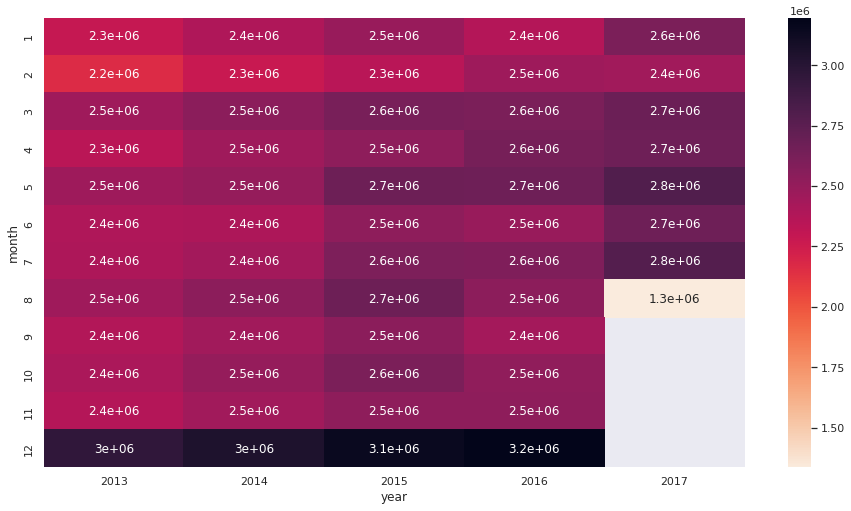

In [31]:
sns.heatmap(SalesWithTransactionsDataFramePivoted, annot=True, cmap='rocket_r')

## Which days of the week are the most profitable ?
#### We want to visualize this information as a heatmap, this requires the data in wide format. We use the method pandas.pivot_table() 

In [32]:
SalesWithTransactionsDataFramePivoted2=pd.pivot_table(SalesWithTransactionsDataFrame, values='transactions', index='dayofweek',
                    columns=['month'], aggfunc=np.sum)

In [33]:
SalesWithTransactionsDataFramePivoted2

month,1,2,3,4,5,6,7,8,9,10,11,12
dayofweek,,,,,,,,,,,,
0,1600585.0,1665523.0,1749219.0,1692113.0,1775417.0,1752057.0,1783132.0,1640928.0,1426345.0,1317215.0,1351289.0,1805802.0
1,1616713.0,1574078.0,1719096.0,1734193.0,1720935.0,1622719.0,1709681.0,1593269.0,1392675.0,1266425.0,1312582.0,1946931.0
2,1643455.0,1587987.0,1758303.0,1765286.0,1745767.0,1641313.0,1826438.0,1523068.0,1322274.0,1367598.0,1333585.0,1772640.0
3,1631446.0,1542787.0,1687053.0,1634807.0,1668817.0,1650783.0,1662239.0,1450097.0,1248562.0,1394981.0,1175061.0,1697895.0
4,1751964.0,1664263.0,1787817.0,1716388.0,1902331.0,1708945.0,1801222.0,1641888.0,1331001.0,1433433.0,1348145.0,1593421.0
5,2076594.0,1938302.0,2123769.0,2150217.0,2210520.0,2062354.0,2079554.0,1954259.0,1518604.0,1704163.0,1692237.0,1900057.0
6,1835441.0,1734994.0,2092656.0,1940527.0,2088892.0,2044008.0,1964940.0,1742062.0,1572358.0,1564419.0,1664974.0,1641062.0


### From the figure below we observe that Saturdays and Sundays are the most profitable ones in terms of transactions made.

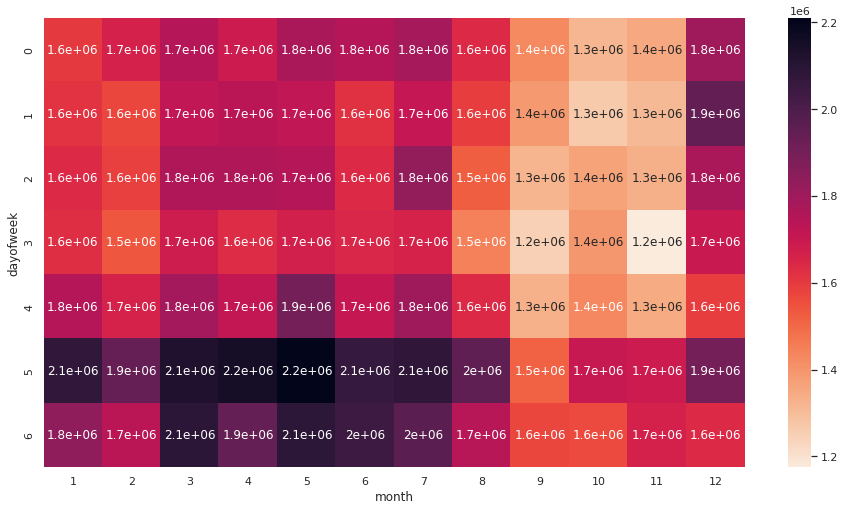

In [34]:
sns.heatmap(SalesWithTransactionsDataFramePivoted2, annot=True,cmap='rocket_r')

# 2. Analysis of stores

In [48]:
SalesAndStoresDataFrame=pd.merge(SalesDataFrame,StoresDataFrame,on='store_nbr')

In [62]:
SalesAndStoresDataFrame['month']=pd.DatetimeIndex(SalesAndStoresDataFrame['date']).month

In [67]:
SalesAndStoresDataFramePivoted=pd.pivot_table(SalesAndStoresDataFrame, values='sales', index='store_nbr',
                    columns=['month'], aggfunc=np.sum)

### We observe from the figure below that stores: 3, 44,45,47 and 49 are the one with the most sales.

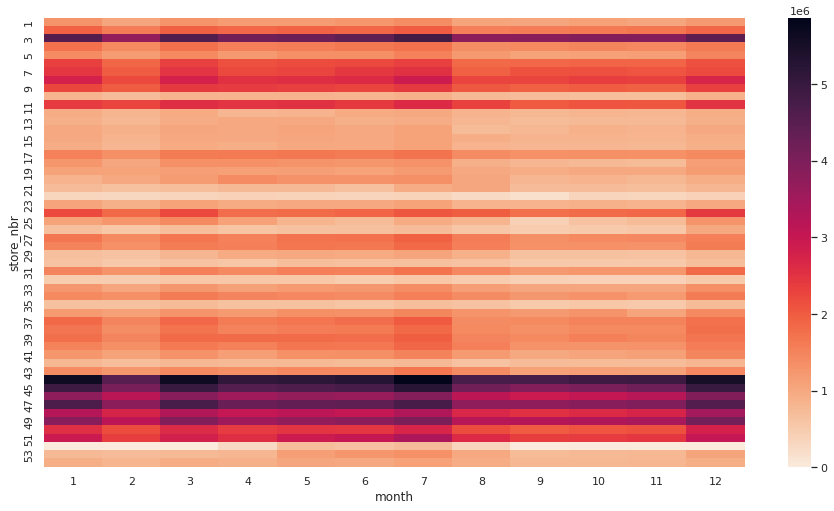

In [70]:
sns.heatmap(SalesAndStoresDataFramePivoted, annot=False,cmap='rocket_r')

# 3. Analysis of products

In [73]:
SalesAndStoresDataFramePivoted2=pd.pivot_table(SalesAndStoresDataFrame, values='sales', index='store_nbr',
                    columns=['family'], aggfunc=np.sum)

In [75]:
SalesAndStoresDataFramePivoted2

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
store_nbr,,,,,,,,,,,,,,,,,,,,,
1,5475.0,0.0,4056.0,2673769.0,211.0,5.699922e+05,16786.0,1078525.0,1054354.0,2.070371e+05,...,5399.0,5.276083e+05,217534.0,5850.0,8913.0,4.786214e+05,135979.562500,2.443330e+06,289.0,43689.007812
2,9100.0,84.0,7936.0,4153912.0,239.0,9.242728e+05,13384.0,1625869.0,1436860.0,4.114851e+05,...,6459.0,8.499158e+05,442836.0,9140.0,9603.0,8.194404e+05,210382.484375,2.781594e+06,770.0,54246.957031
3,15647.0,672.0,16189.0,11351589.0,540.0,1.937379e+06,48450.0,3474432.0,3436852.0,6.646700e+05,...,20476.0,1.366489e+06,847967.0,19678.0,29765.0,1.905238e+06,618877.937500,8.613316e+06,1264.0,178950.281250
4,6767.0,24.0,6890.0,3668136.0,266.0,6.828820e+05,10749.0,1489848.0,1329186.0,3.637768e+05,...,5879.0,6.224704e+05,383983.0,7147.0,9098.0,7.560216e+05,167925.265625,2.639588e+06,350.0,55071.074219
5,9194.0,215.0,8684.0,2533831.0,230.0,6.428546e+05,26176.0,1667748.0,871283.0,4.152710e+05,...,6569.0,4.771044e+05,450166.0,3199.0,8024.0,4.196304e+05,147991.125000,1.653582e+06,813.0,22358.994141
6,9028.0,12.0,9539.0,5063106.0,76.0,9.191028e+05,15753.0,2081127.0,1612034.0,5.753604e+05,...,6161.0,8.341263e+05,541193.0,9950.0,13085.0,1.062760e+06,236798.187500,2.893384e+06,446.0,73180.351562
7,7150.0,48.0,6142.0,5592609.0,211.0,1.082198e+06,18965.0,1770749.0,2063308.0,2.846068e+05,...,11172.0,8.800137e+05,359193.0,6481.0,11638.0,1.018634e+06,302128.218750,5.576834e+06,536.0,96940.789062
8,8890.0,142.0,12104.0,6347150.0,317.0,1.267688e+06,24976.0,2124056.0,2373813.0,4.690508e+05,...,13869.0,8.745428e+05,551520.0,17100.0,18958.0,1.008141e+06,356927.937500,5.152226e+06,710.0,93852.187500
9,23358.0,336.0,9283.0,4617396.0,0.0,9.558400e+05,16257.0,2899366.0,1255925.0,9.845036e+05,...,2790.0,6.347711e+05,746631.0,5696.0,11495.0,8.148546e+05,149475.921875,1.632022e+06,10190.0,28433.320312


### For illustration purposes let's assume we want to focus on the AUTOMOTIVE family of products

In [85]:
automotiveFilter=SalesAndStoresDataFrame['family']=='AUTOMOTIVE'

In [87]:
SalesAndStoresDataFrame[automotiveFilter]

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,month
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0.0,Quito,Pichincha,D,13,1
1,1,2013-01-01,1,AUTOMOTIVE,0.000000,0.0,Quito,Pichincha,D,13,1
2,2,2013-01-01,1,AUTOMOTIVE,0.000000,0.0,Quito,Pichincha,D,13,1
3,3,2013-01-01,1,AUTOMOTIVE,0.000000,0.0,Quito,Pichincha,D,13,1
4,4,2013-01-01,1,AUTOMOTIVE,0.000000,0.0,Quito,Pichincha,D,13,1
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,AUTOMOTIVE,438.132996,0.0,Quito,Pichincha,B,6,8
3000884,3000884,2017-08-15,9,AUTOMOTIVE,154.552994,1.0,Quito,Pichincha,B,6,8
3000885,3000885,2017-08-15,9,AUTOMOTIVE,2419.729004,148.0,Quito,Pichincha,B,6,8
3000886,3000886,2017-08-15,9,AUTOMOTIVE,121.000000,8.0,Quito,Pichincha,B,6,8


### The following figure shows the evolution of automotive products accross time and city.

#### We notice that December is the best month accross all cities considered.

#### Quito and Cayambe are the top peforming cities as far as automotive products are concerned.

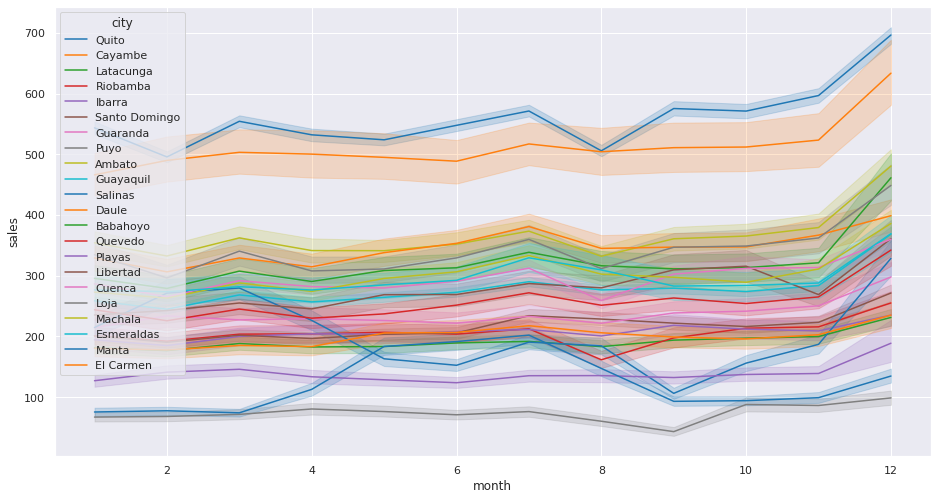

In [90]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(data=SalesAndStoresDataFrame[automotiveFilter],x='month', y='sales',hue='city',palette="tab10")